In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
# provider = IBMQ.get_provider("ibm-q")
provider = IBMQ.get_provider(hub='ibm-q-education', group='yale-uni-2', project='cpsc647-quantum')
# device = provider.get_backend('ibmq_lima') #run on ibmq_lima (5-qbit QC)

In [2]:
device_names =  ['ibmq_lima', 'ibmq_bogota', 'ibmq_santiago', 'ibmq_manila', 'ibmq_quito', 'ibmq_belem', 'ibmq_casablanca', 'ibmq_jakarta', 'ibm_lagos', 'ibm_perth'  ]
device = [0]*len(device_names)
for i in range(len(device_names)):
    device[i] = provider.get_backend(device_names[i])
    print("Device", i , "=", device[i])


Device 0 = ibmq_lima
Device 1 = ibmq_bogota
Device 2 = ibmq_santiago
Device 3 = ibmq_manila
Device 4 = ibmq_quito
Device 5 = ibmq_belem
Device 6 = ibmq_casablanca
Device 7 = ibmq_jakarta
Device 8 = ibm_lagos
Device 9 = ibm_perth


In [6]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate


def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [8]:
n = 2
oracle = dj_oracle("balanced",n)
dj = dj_algorithm(oracle, n)
print(dj)

     ┌───┐     ┌─────────┐┌───┐┌─┐   
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├───
     ├───┤     │         │├───┤└╥┘┌─┐
q_1: ┤ H ├─────┤1 Oracle ├┤ H ├─╫─┤M├
     ├───┤┌───┐│         │└───┘ ║ └╥┘
q_2: ┤ X ├┤ H ├┤2        ├──────╫──╫─
     └───┘└───┘└─────────┘      ║  ║ 
c: 2/═══════════════════════════╩══╩═
                                0  1 


In [9]:
transpiled_dj = [0]*len(device)
for i in range(len(device)):
    print("============================================")
    print(device[i])
    transpiled_dj[i] = transpile(dj, device[i], optimization_level=3, scheduling_method='alap')
    print(transpiled_dj[i])
    print("============================================")

ibmq_lima
               ┌──────────────────┐                                 »
ancilla_0 -> 0 ┤ Delay(28816[dt]) ├─────────────────────────────────»
               ├─────────────────┬┘┌──────────┐   ┌────┐   ┌───────┐»
      q_1 -> 1 ┤ Delay(2176[dt]) ├─┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(π) ├»
               ├─────────────────┴┐└──────────┘   └────┘   └───────┘»
ancilla_1 -> 2 ┤ Delay(28816[dt]) ├─────────────────────────────────»
               └───┬─────────┬────┘   ┌────┐   ┌──────────┐  ┌───┐  »
      q_2 -> 3 ────┤ Rz(π/2) ├────────┤ √X ├───┤ Rz(-π/2) ├──┤ X ├──»
                   ├─────────┴┐       ├────┤   └┬───────┬─┘  └─┬─┘  »
      q_0 -> 4 ────┤ Rz(-π/2) ├───────┤ √X ├────┤ Rz(π) ├──────■────»
                   └──────────┘       └────┘    └───────┘           »
          c: 2/═════════════════════════════════════════════════════»
                                                                    »
«                                                                        
«ancil

               ┌──────────────────┐                                 »
ancilla_0 -> 0 ┤ Delay(28848[dt]) ├─────────────────────────────────»
               ├─────────────────┬┘┌──────────┐   ┌────┐   ┌───────┐»
      q_1 -> 1 ┤ Delay(2496[dt]) ├─┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(π) ├»
               ├─────────────────┴┐└──────────┘   └────┘   └───────┘»
ancilla_1 -> 2 ┤ Delay(28848[dt]) ├─────────────────────────────────»
               └───┬─────────┬────┘   ┌────┐   ┌──────────┐  ┌───┐  »
      q_2 -> 3 ────┤ Rz(π/2) ├────────┤ √X ├───┤ Rz(-π/2) ├──┤ X ├──»
                   ├─────────┴┐       ├────┤   └┬───────┬─┘  └─┬─┘  »
      q_0 -> 4 ────┤ Rz(-π/2) ├───────┤ √X ├────┤ Rz(π) ├──────■────»
                   └──────────┘       └────┘    └───────┘           »
          c: 2/═════════════════════════════════════════════════════»
                                                                    »
«                                                                        
«ancilla_0 -> 0 

               ┌─────────────────┐                                 »
ancilla_0 -> 0 ┤ Delay(6624[dt]) ├─────────────────────────────────»
               └───┬──────────┬──┘   ┌────┐    ┌───────┐           »
      q_0 -> 1 ────┤ Rz(-π/2) ├──────┤ √X ├────┤ Rz(π) ├──────■────»
               ┌───┴──────────┴──┐   └────┘    └───────┘      │    »
ancilla_1 -> 2 ┤ Delay(6624[dt]) ├────────────────────────────┼────»
               └───┬─────────┬───┘   ┌────┐   ┌──────────┐  ┌─┴─┐  »
      q_2 -> 3 ────┤ Rz(π/2) ├───────┤ √X ├───┤ Rz(-π/2) ├──┤ X ├──»
               ┌───┴─────────┴───┐   └────┘   └──────────┘  └───┘  »
ancilla_2 -> 4 ┤ Delay(6624[dt]) ├─────────────────────────────────»
               ├─────────────────┤┌──────────┐   ┌────┐   ┌───────┐»
      q_1 -> 5 ┤ Delay(1824[dt]) ├┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(π) ├»
               ├─────────────────┤└──────────┘   └────┘   └───────┘»
ancilla_3 -> 6 ┤ Delay(6624[dt]) ├─────────────────────────────────»
               └─────────────────┘

ibm_perth


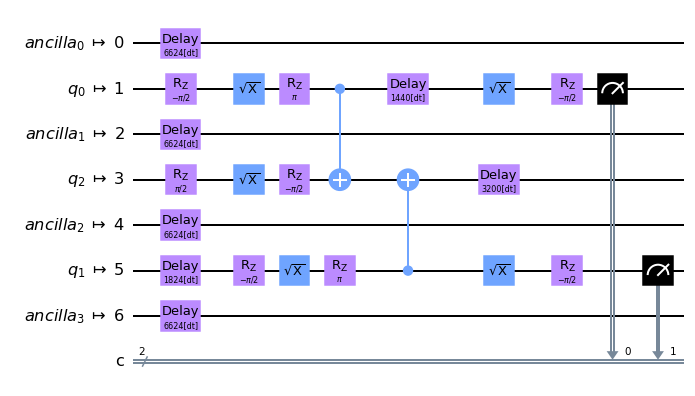

In [22]:
j = 9
print(device[j])
transpiled_dj[j].draw('mpl')